In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

## 1. Importing data

In [2]:
train = pd.read_csv('../data/diamonds_train.csv')

In [3]:
test = pd.read_csv('../data/diamonds_test.csv')

## 2. Exploratory Data Analysis

### 2.1. Overview of data

In [4]:
train.shape

(40455, 10)

In [5]:
train.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.21,Premium,J,VS2,62.4,58.0,4268,6.83,6.79,4.25
1,0.32,Very Good,H,VS2,63.0,57.0,505,4.35,4.38,2.75
2,0.71,Fair,G,VS1,65.5,55.0,2686,5.62,5.53,3.65
3,0.41,Good,D,SI1,63.8,56.0,738,4.68,4.72,3.00
4,1.02,Ideal,G,SI1,60.5,59.0,4882,6.55,6.51,3.95


In [6]:
# main statistic metrics

train.describe().round(2)

,carat,depth,table,price,x,y,z
count,40455.00,40455.00,40455.00,40455.00,40455.00,40455.00,40455.00
mean,0.80,61.75,57.45,3928.44,5.73,5.73,3.54
std,0.48,1.43,2.23,3992.42,1.12,1.15,0.70
min,0.20,43.00,43.00,326.00,0.00,0.00,0.00
25%,0.40,61.00,56.00,945.00,4.71,4.72,2.91
50%,0.70,61.80,57.00,2397.00,5.69,5.71,3.52
75%,1.04,62.50,59.00,5331.00,6.54,6.54,4.04
max,4.50,79.00,95.00,18823.00,10.23,58.90,8.06


In [7]:
# null values: there are not null values.

train.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [8]:
test.head()

,id,carat,cut,color,clarity,depth,table,x,y,z
0,0,0.79,Very Good,F,SI1,62.7,60.0,5.82,5.89,3.67
1,1,1.20,Ideal,J,VS1,61.0,57.0,6.81,6.89,4.18
2,2,1.57,Premium,H,SI1,62.2,61.0,7.38,7.32,4.57
3,3,0.90,Very Good,F,SI1,63.8,54.0,6.09,6.13,3.90
4,4,0.50,Very Good,F,VS1,62.9,58.0,5.05,5.09,3.19


In [9]:
# dropping id colum from test
test.drop('id', axis=1, inplace=True)

### 2.2. Data Analysis and preprocessing

After training and testing our machine learning model we are going to analyse deeply the data and we are going to clean it.  (SAY MORE ABOUT THIS CHANGES AND WHY)

All the changes will be made in the train dataframe as in the test one.

#### 2.2.1. Adding volume column

In [10]:
# adding the volume column in train and test data frames.

#train['volume'] = train['x']*train['y']*train['z']
#test['volume'] = test['x']*test['y']*test['z']

# dropping x, y, z due to they don't give a plus of information.

#train.drop(['x', 'y', 'z'], axis=1, inplace=True)
#test.drop(['x', 'y', 'z'], axis=1, inplace=True)

#### 2.2.2. Outliers analysis

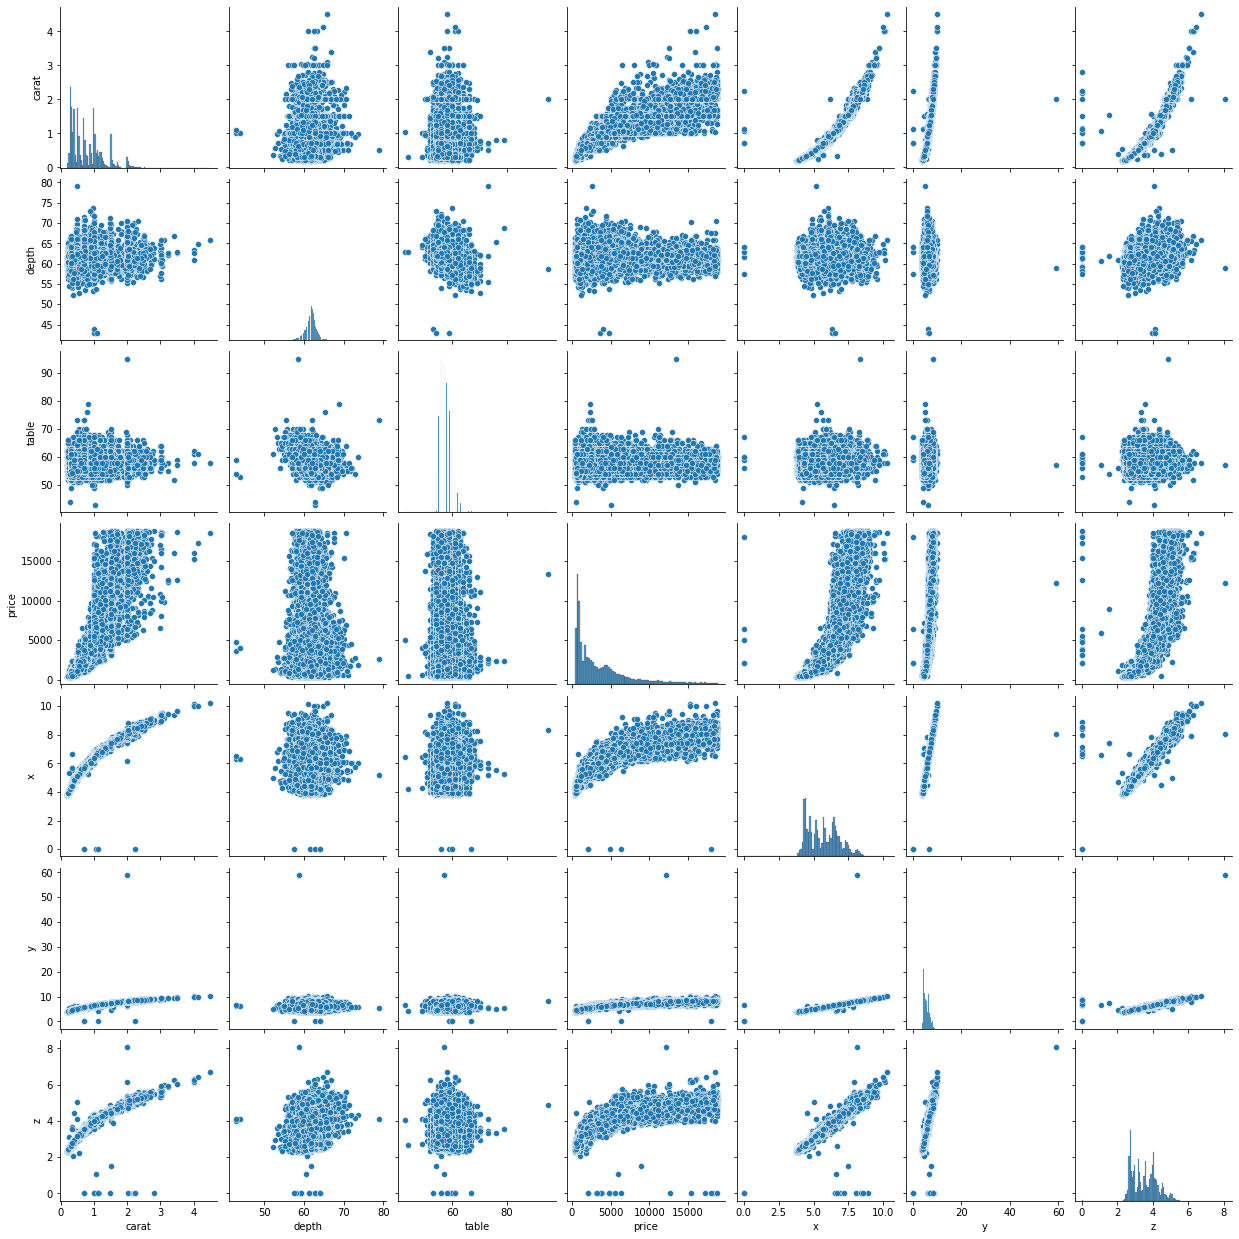

In [11]:
# analysing the outliers in each correlation

sns.pairplot(train)

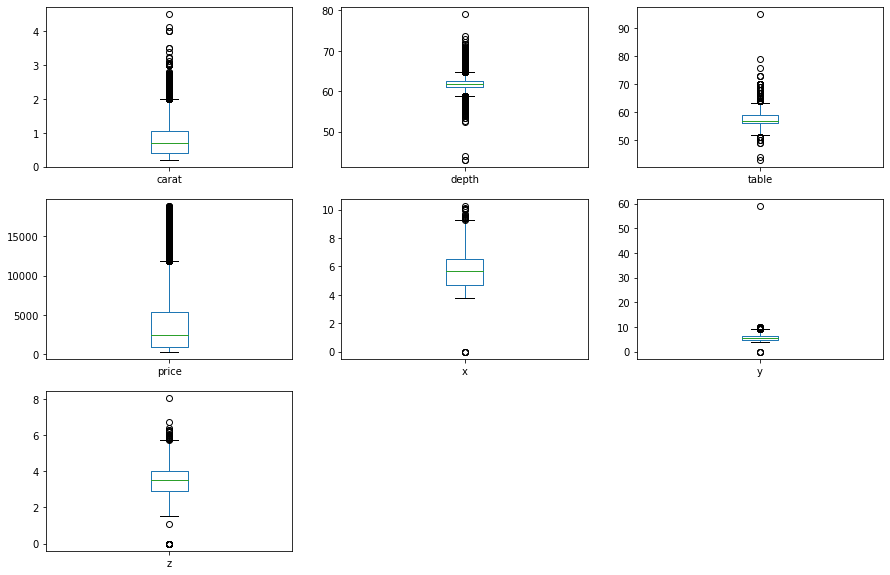

In [12]:
# box plot

train.plot(kind='box', figsize=(15,10), subplots=True, layout=(3,3))
plt.show()

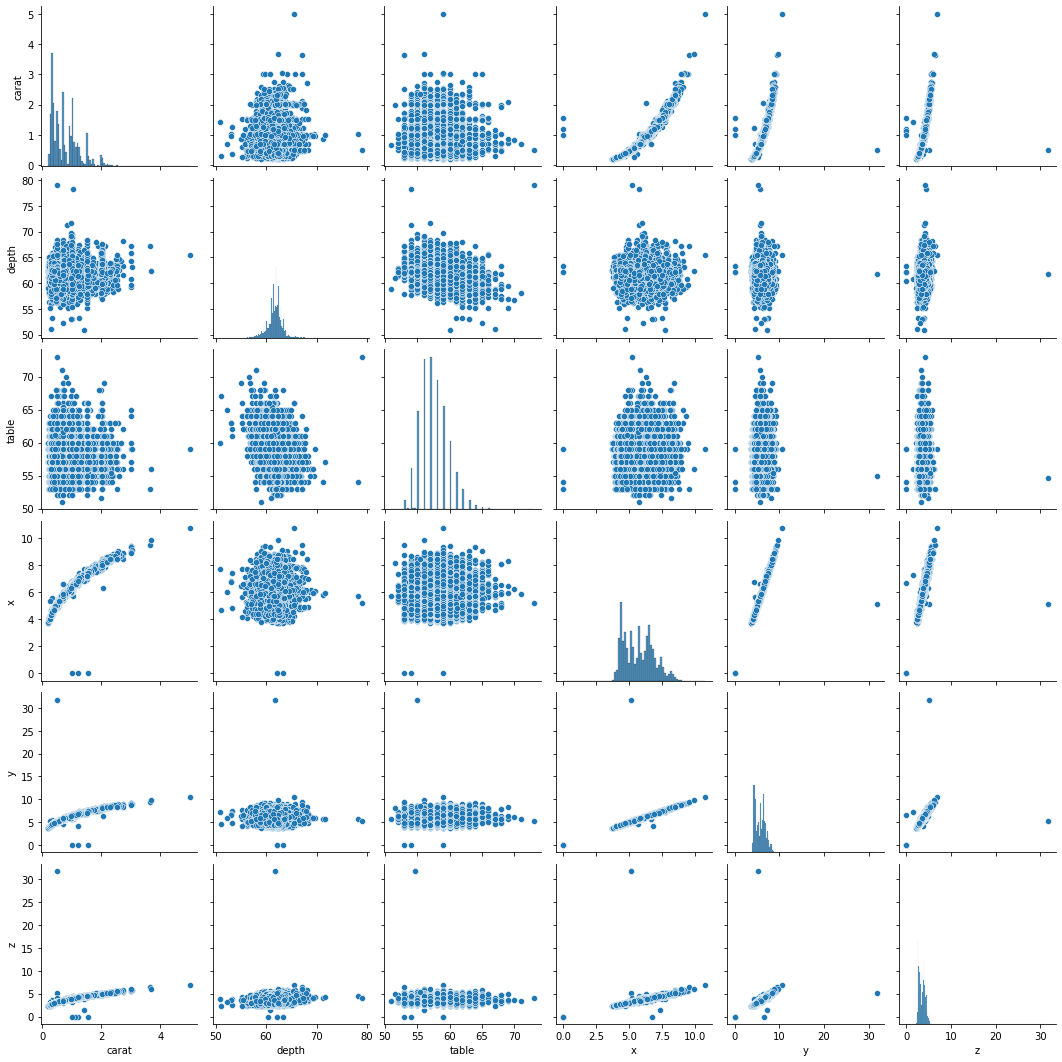

In [13]:
sns.pairplot(test)

In [14]:
# function to delete the outliers

def remove_outliers(df, var):
    a = []
    
    q1 = df[var].quantile(.25)
    q2 = df[var].quantile(.5)
    q3 = df[var].quantile(.75)
    
    iqr = q3-q1
    
    ulim = float(q3+(1.5*iqr))
    llim = float(q1-(1.5*iqr))
    
    for i in df[var]:
        if i > ulim:
            i = np.NaN
        elif i < llim:
            i = np.NaN
        else:
            i=i
        a.append(i)
        
    return a

In [15]:
# applying the outliers remove function to train df

for col in train.select_dtypes(exclude='object').columns:
    train[col] = remove_outliers(train, col)

In [16]:
# completing the outliets with mean values

for i in train.select_dtypes(exclude='object').columns:
    train[i] = train[i].fillna(train[i].mean())

In [17]:
# checking there are not null values
train.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [18]:
# applying the outliers remove function to test df 

for col in test.select_dtypes(exclude='object').columns:
    test[col] = remove_outliers(test, col)

In [19]:
# completing the outliets with mean values in test data frame

for i in test.select_dtypes(exclude='object').columns:
    test[i] = test[i].fillna(train[i].mean())

#### 2.2.3. Label encoding data

## 3. Modeling

### 3.1. Categorical features

In [23]:
TARGET = 'price'

CAT_FEATURES = ['cut', 'color', 'clarity']
NUM_FEATURES = ['carat', 'depth', 'table', 'x', 'y', 'z']

#### 3.1. Categorical features

In [24]:
for categorical_feature in CAT_FEATURES:
    
    train[categorical_feature] = train[categorical_feature].astype('category')
    test[categorical_feature] = test[categorical_feature].astype('category')

In [25]:
# encoding categorical for train df
categorical_df = pd.get_dummies(train[CAT_FEATURES])
numerical_df = train[NUM_FEATURES]
price_df = train[TARGET]

train_df = pd.concat([categorical_df, numerical_df, price_df], axis=1)
train_df

,cut_Fair,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_D,color_E,color_F,color_G,color_H,...,clarity_VS2,clarity_VVS1,clarity_VVS2,carat,depth,table,x,y,z,price
0,0,0,0,1,0,0,0,0,0,0,...,1,0,0,1.210000,62.400000,58.0,6.83,6.79,4.25,4268.000000
1,0,0,0,0,1,0,0,0,0,1,...,1,0,0,0.320000,63.000000,57.0,4.35,4.38,2.75,505.000000
2,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0.710000,61.777135,55.0,5.62,5.53,3.65,2686.000000
3,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0.410000,63.800000,56.0,4.68,4.72,3.00,738.000000
4,0,0,1,0,0,0,0,0,1,0,...,0,0,0,1.020000,60.500000,59.0,6.55,6.51,3.95,4882.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40450,0,0,1,0,0,0,0,0,1,0,...,0,0,0,1.340000,62.700000,57.0,7.10,7.04,4.43,10070.000000
40451,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0.747587,61.777135,60.0,8.31,8.25,4.73,3157.454144
40452,0,0,1,0,0,0,0,0,0,1,...,0,0,0,1.010000,62.700000,56.0,6.37,6.42,4.01,5457.000000
40453,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0.330000,61.900000,54.3,4.45,4.47,2.76,456.000000


In [26]:
# encoding categorical for test df
categorical_test_df = pd.get_dummies(test[CAT_FEATURES])
numerical_test_df = test[NUM_FEATURES]


test_df = pd.concat([categorical_test_df, numerical_test_df], axis=1)
test_df

,cut_Fair,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_D,color_E,color_F,color_G,color_H,...,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2,carat,depth,table,x,y,z
0,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0.79,62.7,60.0,5.82,5.89,3.67
1,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,1.20,61.0,57.0,6.81,6.89,4.18
2,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,1.57,62.2,61.0,7.38,7.32,4.57
3,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0.90,63.8,54.0,6.09,6.13,3.90
4,0,0,0,0,1,0,0,1,0,0,...,1,0,0,0,0.50,62.9,58.0,5.05,5.09,3.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13480,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0.57,61.9,56.0,5.35,5.32,3.30
13481,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0.71,62.2,55.0,5.71,5.73,3.56
13482,0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,0.70,61.6,55.0,5.75,5.71,3.53
13483,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0.70,58.8,57.0,5.85,5.89,3.45


### 3.2. Machine Learning models

In [27]:
# creating X and y 

X = train_df.drop(['price'], 1)
y = train_df['price']

In [28]:
# train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#### 3.2.2. Regression

In [29]:
# training the model

regr = LinearRegression()
model = regr.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [30]:
# RMSE 

from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)**0.5

1427.1120404627816

#### 3.2.2. Random Forest

In [31]:
# training the model 

rf = RandomForestRegressor()
model_rf = rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [32]:
# RMSE error metric

print("RMSE: {}".format(np.sqrt(mean_squared_error((y_test),(y_pred)))))

RMSE: 818.9171064651181


In [39]:
# evaluating the model

model_rf.score(X_test, y_test)

0.905385201958636

In [34]:
# predictions using test df

y_pred_2 = rf.predict(test_df)
y_pred_2

array([2949.62      , 5409.09      , 9363.90179008, ..., 3019.46      ,
       2202.23      ,  830.52      ])

## Submission

In [48]:
predictions = pd.DataFrame({'id': test_df.index, 'price': y_pred_2})

In [46]:
predictions

,id,price
0,0,2949.620000
1,1,5409.090000
2,2,9363.901790
3,3,4084.360000
4,4,1700.990000
...,...,...
13480,13480,1906.980000
13481,13481,2588.049083
13482,13482,3019.460000
13483,13483,2202.230000


In [49]:
predictions.to_csv('../submissions/predictions_01.csv', index=False)

In [50]:
predictions['price'].mean()

3184.924711519722

In [51]:
predictions.shape

(13485, 2)